In [231]:
import harp
import utils
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
import cv2
import numpy as np

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-02-28T17-52-29/Expander/'
settings_datafolder = r'../temp_data/2024-02-28T17-52-29/SessionSettings/'
rules_datafolder = r'../temp_data/2024-02-28T17-52-29/RuleSettings/'
video_datafolder = r'../temp_data/2024-02-28T17-52-29/VideoData/'

In [232]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-02-28 17:52:29.400576  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-02-28 17:52:29.400576  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


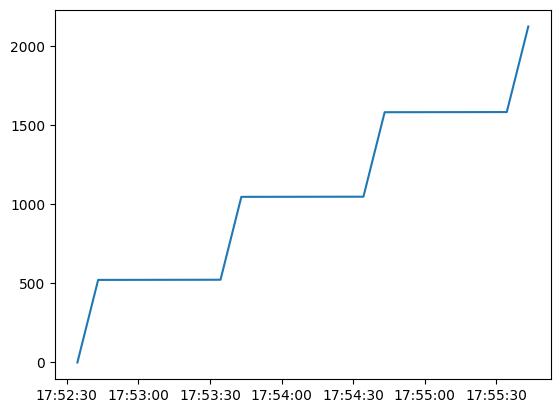

In [233]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [234]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

DotMap(lineMappings=DotMap(odorMap=[DotMap(name='OdorA', line=6), DotMap(name='OdorB', line=7), DotMap(name='OdorC', line=8), DotMap(name='OdorD', line=9)], auxLine=0, portLine=0, vacuumLine=2), metadata=DotMap(switchTime1=0.01, switchTime2=0.02, useVacuum=True, vacuumDelay=0.005, vacuumDuration=0.05, chargeTime=0.2, minimumPokeTime=0.1, minOdorDelivery=0.1, maxOdorDelivery=8.0, loggingRootPath='C:\\Users\\Delphi1983\\Delphi\\temp_data', animalId='plimbo', remoteTransferRootPath='', maximumPokeTime=10.0, robocopyTimeInterval=3600.0, showHarpLeds=False, maxVideoLength=20.0), cameraProperties=DotMap(imagingRate=60.0, exposureTime=10000, postEventTime=2.5, preEventTime=2.5))


In [244]:
# Using the consolidated data sets, do an example plot centered around a poke event

# Get all the poke onset events, then index to pick a single event. Ultimately we just need to choose a timestamp value to center our plot around.
poke_event = merged["poke_events"][merged["poke_events"]==True].iloc[[18]] # as an example we here pick the time 3rd poke event time
poke_event_time = poke_event.index[0]

# Create a time window around the time of this event
time_offset = 0.1 # 10 second time offset around the event
start_time = poke_event_time - pd.Timedelta(seconds=time_offset)
end_time = poke_event_time + pd.Timedelta(seconds=time_offset)

# Slice the data in this time window
event_data = merged[start_time : end_time]
event_vid = video_data[start_time : end_time]

# Construct a plot of this time window
fig = plt.figure()

plt.plot([poke_event_time, poke_event_time], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.scatter(event_vid.index, np.ones((1, len(event_vid.index))) * 6, c='k', s=0.1)
plt.xticks(rotation=90)

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95, 6.05])
ax.set_yticklabels(['event', 'poke', 'port_line', 'odorA', 'odorB', 'odorC', 'video_frames'])

# Get all frames
frames = [f for f in video.frames(video_data)]

# Get the frame where this event occurred
debug_offset = 105
idx = np.where(video_data.index >= poke_event_time)[0][0] + debug_offset
frame = frames[idx]

plt.figure()
ax = plt.gca()
plt.imshow(frame)
ax.axis('off')

# annotated_frames = []
# for i, f in enumerate(frames):
#     cur_t = vid_frames.index[i]
#     relative_t = (cur_t - poke_event_time).total_seconds()
#     cur_state = merged.ffill().loc[merged.ffill().index >= cur_t].iloc[0]
#     aux_state = cur_state['poke_events']
#     cv2.putText(f, f'{cur_t}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
#     cv2.putText(f, f'{relative_t}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
#     cv2.putText(f, f'Aux: {aux_state}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
#     annotated_frames.append(f)

# video.export(annotated_frames, 'test.mp4', 50)

# extract other information about this event
# current_rule = rule_settings[rule_settings.index <= poke_event_time]["metadata"].iloc[[-1]]
# current_state = event_data.ffill()[event_data.index <= poke_event_time].iloc[[-1]] 

# on_odors = [odor_name for odor_name in ['odorA_state', 'odorB_state', 'odorC_state'] if current_state[odor_name].values[0]]